In [ ]:
# -*- coding: utf-8 -*-
#  File: otus_adv_hw1_automl_mljar.ipynb
#  Project: 'OTUS.ADV Homework #1'
#  Created by Gennady Matveev (gm@og.ly) on 06-01-2022.

# **$Homework$** **$1$**  
**OTUS Machine Learning Advanced**

Goals:   
- AutoML: try out automatic feature generation/selection and modelling; 
- Compare AutoML performance in AutoML mljar-supervised library  
    https://github.com/mljar/mljar-supervised  
    with baseline and two out of the box models.

In addition, will try ensembling of autoML models.

Means:  
- AutoML tasks will be given to **mljar-supervised**;
- All preprocessing and pipelines management will be done in ATOM  
    https://tvdboom.github.io/ATOM/about/.

Dataset:
- Richter's Predictor: Modeling Earthquake Damage  
https://www.drivendata.org/competitions/57/nepal-earthquake/data/

Abbreviations:
- BO: bayesian optimization
- BA: balanced accuracy
- H/P: hyperparameters
- OOB: out of the box

### Choice of models
- Random Forest and CatBoost classifiers will compete with AutoML solution

Methodology:
- OOB models' hyperparameters will be tuned with BO primarily to get some CV statistics and to level up the competition ground.  
- Weighted F1 score will be used as the main performance metrics following  suggestion of the  
competition organizers.  

<a href="https://colab.research.google.com/github/oort77/OTUS_ADV_HW1/blob/main/notebooks/otus_adv_hw1_automl_mljar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google colab specific part

Typical runtime on Colab is around 2.5 hours unless you set **total_time_limit** of automl_model in _MLJAR AutoML section_ to lower value.
. Please uncomment below to install the notebook dependencies.  

Dependencies installation requires restart of runtime.


In [ ]:
# !pip install -r 'https://drive.google.com/uc?export=download&id=1VmHDlGXo1IMHZ2kAT5IW4r4suWAfmiXs'

### Import libraries and setup notebook

In [ ]:
import os
import pandas as pd
import numpy as np
from atom import ATOMClassifier, ATOMModel
from sklearn.preprocessing import StandardScaler, \
                    RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from supervised.automl import AutoML # mljar-supervised

import matplotlib.pyplot as plt
import seaborn as sns

import gdown
import random
import shutil
import warnings
from IPython.core.display import display, HTML

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


#### Miscellaneius settings 

In [ ]:
%matplotlib inline
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize']=(10,5)
sns.set(rc = {'figure.figsize':(8,5)})
warnings.filterwarnings("ignore")
pd.options.display.precision = 4

#### ML parameters

In [ ]:
random_state = 17
n_jobs = -1 # Try 2 on Colab
models = ["RF", "LGB"] 
metric = ["F1_weighted", "LogLoss", "BA", "precision_weighted"] # BA stands for balanced_accuracy

#### Parameters of BO

In [ ]:
n_calls = 25
n_initial_points = 16

#### Helper function

In [ ]:
def nice_metric_table(df: pd.DataFrame, metric: list) -> pd.DataFrame:
    df1 = pd.DataFrame()
    for col in df.columns:
        if col.startswith("time"):
            df.drop(columns=col, inplace=True)
    for c in df.columns:
        df1 = pd.concat([df1, pd.DataFrame([pd.Series(x)
                        for x in df[c]])], axis=1)
    cols = [(init, metr) for init in df.columns for metr in metric]
    df1.columns = pd.MultiIndex.from_tuples(cols)
    df1.index = df.index
    return df1

### Load data

In [ ]:
# Download data from Google Drive
if os.path.isdir("../data") == False:
    !mkdir ../data

url = "https://drive.google.com/uc?export=download&id=1Z2PeT1anXzFc49yukOQhJbKi0HNfz2wd"
gdown.download(url, output="../data/Archive.zip")
shutil.unpack_archive("../data/Archive.zip", "../data")

X = pd.read_csv('../data/train_values.csv',index_col=0)
y = pd.read_csv('../data/train_labels.csv',index_col=0)
df = X.join(y)
df.head()

Downloading...
From: https://drive.google.com/uc?export=download&id=1Z2PeT1anXzFc49yukOQhJbKi0HNfz2wd
To: /home/gm/notebooks/OTUS/OTUS.ML_ADV/HW1/data/Archive.zip
100%|██████████| 7.25M/7.25M [00:00<00:00, 36.1MB/s]


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


### Take part of data

In [ ]:
rand_part = 0.25 # for testing of computationally expensive parts
partial = 0 # for rapid tests set to 1 and possibly change rand_part ratio above

# Randomly select rand_part of rows
part = sorted(random.choices(range(df.shape[0]), k=int(df.shape[0]*rand_part)))
if partial == 0:
    X, y = df.iloc[:,:-1], df.iloc[:,-1]
else:
    X, y = df.iloc[part,:-1], df.iloc[part,-1]
# df.shape
X.shape, y.shape

((260601, 38), (260601,))

### Initialize ATOM

In [ ]:
atom = ATOMClassifier(X, y, test_size=0.2, n_jobs=n_jobs, verbose=1, 
                      warnings=False, random_state=random_state)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 8 cores.

Dataset stats ==================== >>
Shape: (260601, 39)
Scaled: False
Categorical features: 8 (21.1%)
Outlier values: 126324 (1.6%)
Duplicate samples: 12319 (4.7%)
-------------------------------------
Train set size: 208481
Test set size: 52120
-------------------------------------



#### Preprocessing (minimal)

In [ ]:
atom.impute()
atom.clean(drop_min_cardinality=False)#, strip_categorical=False, drop_max_cardinality=False)
atom.encode()#frac_to_other=0.05)
# atom.add(StandardScaler())
atom.add(RobustScaler())
# atom.gauss()

Fitting Imputer...
Imputing missing values...
Applying data cleaning...
Fitting Encoder...
Encoding categorical columns...
Fitting RobustScaler...
Applying RobustScaler to the dataset...


### OOB models - RandomForest and LightGBM

To put comptitors on the level ground, we will apply Bayesian H/P optimization to OOB models

New branch oob successfully created.

Training ========================= >>
Models: RF, LGB
Metric: f1_weighted, neg_log_loss, balanced_accuracy, precision_weighted


Running BO for Random Forest...


Iteration 25: 100%|██████████| 25/25 [08:07<00:00, 19.51s/it]    


Bayesian Optimization ---------------------------
Best call --> Iteration 20
Best parameters --> {'n_estimators': 10, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': True, 'ccp_alpha': 0.0, 'max_samples': 0.9}
Best evaluation --> f1_weighted: 0.7215   neg_log_loss: -0.625   balanced_accuracy: 0.6303   precision_weighted: 0.7295
Time elapsed: 8m:08s
Fit ---------------------------------------------
Train evaluation --> f1_weighted: 0.7556   neg_log_loss: -0.5322   balanced_accuracy: 0.6699   precision_weighted: 0.7644
Test evaluation --> f1_weighted: 0.7244   neg_log_loss: -0.6157   balanced_accuracy: 0.6348   precision_weighted: 0.7323
Time elapsed: 4.348s
Bootstrap ---------------------------------------
Evaluation --> f1_weighted: 0.7186 ± 0.0013   neg_log_loss: -0.6444 ± 0.0038   balanced_accuracy: 0.631 ± 0.0018   precision_weighted: 0.7252 ± 0.0015
Time elapsed: 19.689s
------------------------------------

Iteration 25: 100%|██████████| 25/25 [03:30<00:00,  8.42s/it]    


Bayesian Optimization ---------------------------
Best call --> Iteration 21
Best parameters --> {'n_estimators': 337, 'learning_rate': 0.2658, 'max_depth': 8, 'num_leaves': 40, 'min_child_weight': 0.0001, 'min_child_samples': 19, 'subsample': 0.9, 'colsample_bytree': 0.6, 'reg_alpha': 10, 'reg_lambda': 0.1}
Best evaluation --> f1_weighted: 0.7344   neg_log_loss: -0.5886   balanced_accuracy: 0.661   precision_weighted: 0.7404
Time elapsed: 3m:30s
Fit ---------------------------------------------
Train evaluation --> f1_weighted: 0.7596   neg_log_loss: -0.5404   balanced_accuracy: 0.6896   precision_weighted: 0.7665
Test evaluation --> f1_weighted: 0.7342   neg_log_loss: -0.586   balanced_accuracy: 0.6586   precision_weighted: 0.7405
Time elapsed: 13.421s
Bootstrap ---------------------------------------
Evaluation --> f1_weighted: 0.7281 ± 0.0007   neg_log_loss: -0.5976 ± 0.0005   balanced_accuracy: 0.6521 ± 0.0014   precision_weighted: 0.7335 ± 0.0008
Time elapsed: 39.675s
-----------

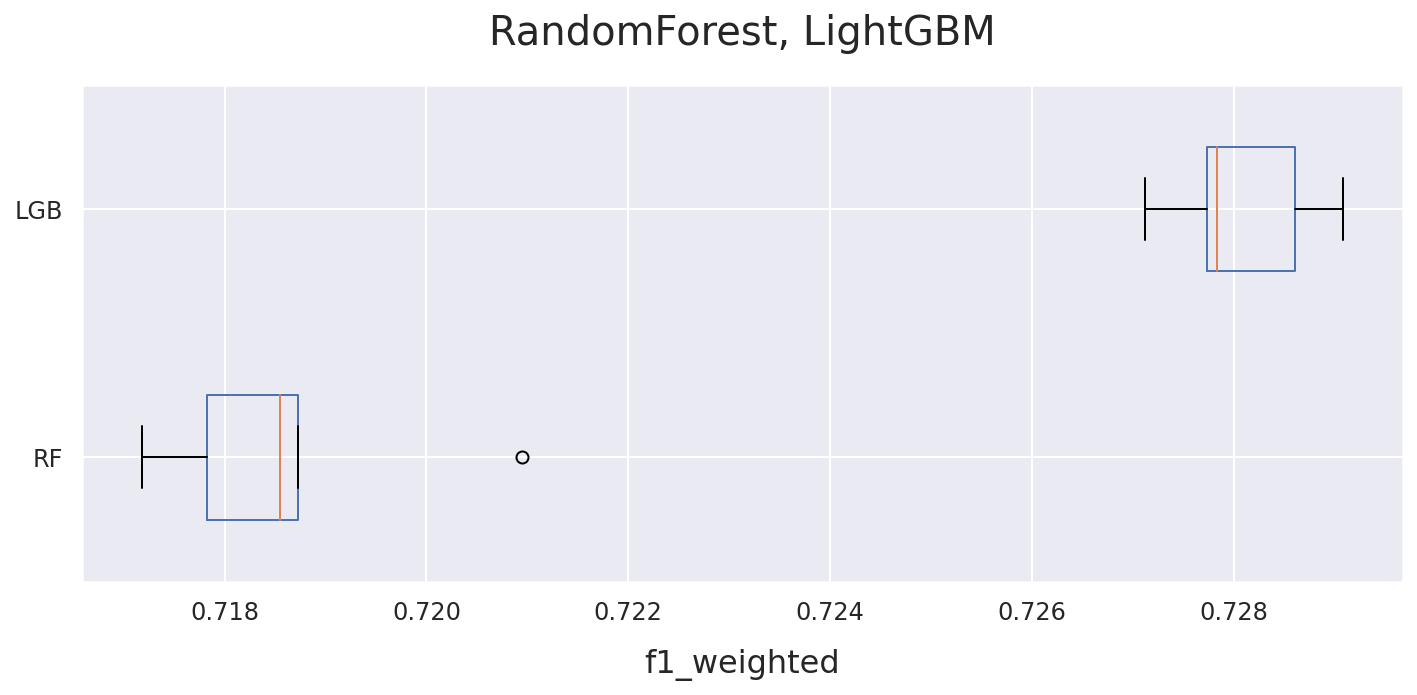

In [ ]:
atom.branch = "oob"

# Fit the models to the data with Bayesian optimisation
atom.run(
    models=["RF", "LGB"],
    metric=metric,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    n_bootstrap=5
)

# Analyze the results
atom.plot_results(title="RandomForest, LightGBM")

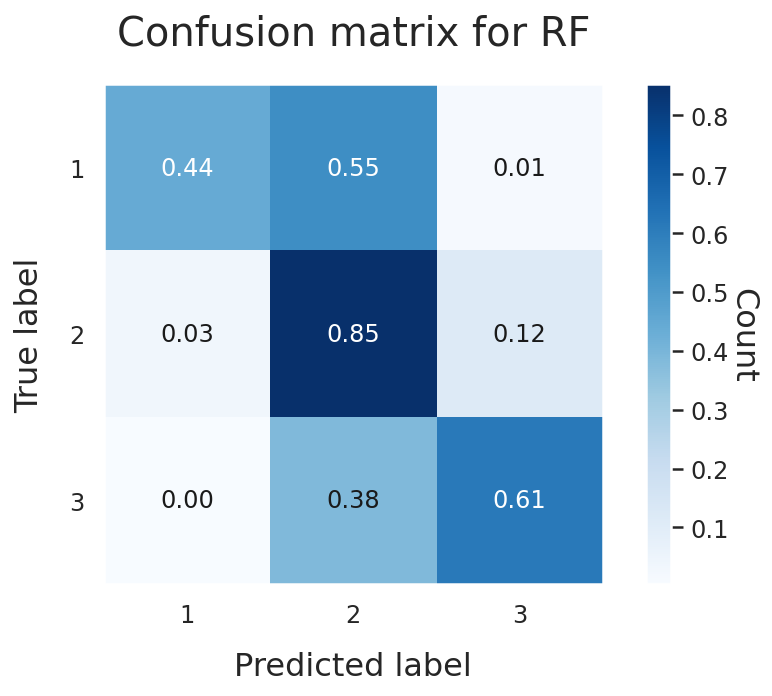

In [ ]:
atom.rf.plot_confusion_matrix(dataset="test", normalize=True, title=f"Confusion matrix for RF", figsize=(8,5)) 

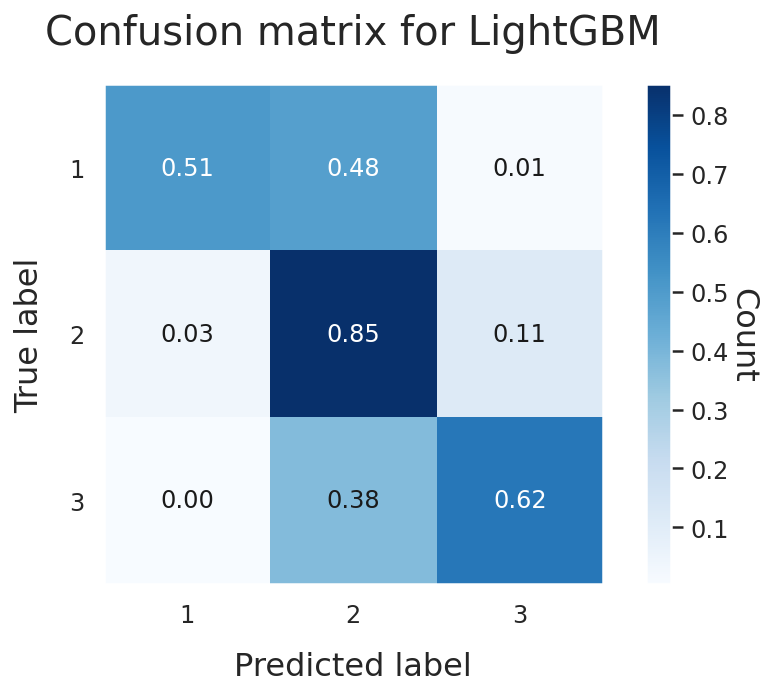

In [ ]:
atom.lgb.plot_confusion_matrix(dataset="test", normalize=True, title=f"Confusion matrix for LightGBM", figsize=(8,5)) 

In [ ]:
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

In [ ]:
atom.branch.status()

Branch: oob
 --> Pipeline: 
   >>> Imputer
     --> strat_num: drop
     --> strat_cat: drop
     --> max_nan_rows: None
     --> max_nan_cols: None
   >>> Cleaner
     --> drop_types: None
     --> strip_categorical: True
     --> drop_max_cardinality: True
     --> drop_min_cardinality: False
     --> drop_duplicates: False
     --> drop_missing_target: True
     --> encode_target: True
   >>> Encoder
     --> strategy: LeaveOneOut
     --> max_onehot: 10
     --> ordinal: None
     --> frac_to_other: None
     --> kwargs: {}
   >>> RobustScaler
     --> with_centering: True
     --> with_scaling: True
     --> quantile_range: (25.0, 75.0)
     --> copy: True
     --> unit_variance: False
 --> Models: RF, LGB


### MLJAR AutoML

In [ ]:
atom.verbose = 2
atom.branch = "auto_ml_from_master"

New branch auto_ml successfully created.


In [ ]:
automl_model = AutoML(mode="Perform", results_path="AutoML", 
                      train_ensemble=True, eval_metric = "f1",
                      random_state=random_state, total_time_limit=7200) #"Explain" "Compete" "Perform" "Optuna", optuna_time_budget=3600

In [ ]:
auto_ml_model = ATOMModel(
    estimator=automl_model,
    acronym="auto_ml_model",
    fullname="MLJAR AutoML",
    needs_scaling=False,
)

atom.run(auto_ml_model)


Training ========================= >>
Models: auto_ml_model
Metric: f1_weighted, neg_log_loss, balanced_accuracy, precision_weighted


Results for MLJAR AutoML:
Fit ---------------------------------------------
Neural Network algorithm was disabled because it doesn't support n_jobs parameter.
Linear algorithm was disabled.
AutoML directory: AutoML
The task is multiclass_classification with evaluation metric f1
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 4 models
1_Default_LightGBM f1 0.73919 trained in 630.88 seconds (1-sample predict time 0.0442 seconds)
2_Default_Xgboost f1 0.736187 trained in 656.23 seconds (1-s

In [ ]:
# Check the new transformer(s) in the branch
atom.branch.status()

Branch: auto_ml
 --> Pipeline: 
   >>> Imputer
     --> strat_num: drop
     --> strat_cat: drop
     --> max_nan_rows: None
     --> max_nan_cols: None
   >>> Cleaner
     --> drop_types: None
     --> strip_categorical: True
     --> drop_max_cardinality: True
     --> drop_min_cardinality: False
     --> drop_duplicates: False
     --> drop_missing_target: True
     --> encode_target: True
   >>> Encoder
     --> strategy: LeaveOneOut
     --> max_onehot: 10
     --> ordinal: None
     --> frac_to_other: None
     --> kwargs: {}
   >>> RobustScaler
     --> with_centering: True
     --> with_scaling: True
     --> quantile_range: (25.0, 75.0)
     --> copy: True
     --> unit_variance: False
 --> Models: auto_ml_model


#### Generated AutoML reports

### AutoML Leaderboard

| Best model   | name                                                             | model_type    | metric_type   |   metric_value |   train_time |   single_prediction_time |
|:-------------|:-----------------------------------------------------------------|:--------------|:--------------|---------------:|-------------:|-------------------------:|
|              | [1_Default_LightGBM](./AutoML/1_Default_LightGBM/README.md)               | LightGBM      | f1            |       0.73919  |       632.82 |                   0.0442 |
|              | [2_Default_Xgboost](./AutoML/2_Default_Xgboost/README.md)                 | Xgboost       | f1            |       0.736187 |       657.93 |                   0.0537 |
|              | [3_Default_CatBoost](./AutoML/3_Default_CatBoost/README.md)               | CatBoost      | f1            |       0.718435 |       110.73 |                   0.0517 |
|              | [4_Default_RandomForest](./AutoML/4_Default_RandomForest/README.md)       | Random Forest | f1            |       0.634537 |        78.36 |                   0.0748 |
|              | [9_LightGBM](./AutoML/9_LightGBM/README.md)                               | LightGBM      | f1            |       0.740825 |       521.11 |                   0.0445 |
|              | [5_Xgboost](./AutoML/5_Xgboost/README.md)                                 | Xgboost       | f1            |       0.742662 |       519.92 |                   0.0532 |
|              | [13_CatBoost](./AutoML/13_CatBoost/README.md)                             | CatBoost      | f1            |       0.721941 |       175.51 |                   0.0509 |
|              | [17_RandomForest](./AutoML/17_RandomForest/README.md)                     | Random Forest | f1            |       0.630691 |        76.89 |                   0.0744 |
|              | [10_LightGBM](./AutoML/10_LightGBM/README.md)                             | LightGBM      | f1            |       0.73766  |       512.29 |                   0.0454 |
|              | [6_Xgboost](./AutoML/6_Xgboost/README.md)                                 | Xgboost       | f1            |       0.735453 |       998.32 |                   0.0547 |
|              | [14_CatBoost](./AutoML/14_CatBoost/README.md)                             | CatBoost      | f1            |       0.725663 |       118.98 |                   0.0521 |
|              | [18_RandomForest](./AutoML/18_RandomForest/README.md)                     | Random Forest | f1            |       0.663159 |       119.6  |                   0.0833 |
|              | [11_LightGBM](./AutoML/11_LightGBM/README.md)                             | LightGBM      | f1            |       0.738019 |       309.03 |                   0.0434 |
|              | [5_Xgboost_GoldenFeatures](./AutoML/5_Xgboost_GoldenFeatures/README.md)   | Xgboost       | f1            |       0.743027 |       539.68 |                   0.0734 |
|              | [19_Xgboost_GoldenFeatures](./AutoML/19_Xgboost_GoldenFeatures/README.md) | Xgboost       | f1            |       0.741909 |       549.65 |                   0.0722 |
|              | [20_Xgboost_GoldenFeatures](./AutoML/20_Xgboost_GoldenFeatures/README.md) | Xgboost       | f1            |       0.743032 |       532.98 |                   0.0731 |
|              | [21_Xgboost](./AutoML/21_Xgboost/README.md)                               | Xgboost       | f1            |       0.741674 |       419.51 |                   0.0523 |
|              | [28_CatBoost](./AutoML/28_CatBoost/README.md)                             | CatBoost      | f1            |       0.724478 |       135.25 |                   0.0511 |
|              | [29_CatBoost](./AutoML/29_CatBoost/README.md)                             | CatBoost      | f1            |       0.723783 |       150.14 |                   0.0515 |
| **the best** | [Ensemble](./AutoML/Ensemble/README.md)                                   | Ensemble      | f1            |       0.744178 |        24.77 |                   0.3661 |

#### AutoML Performance
![AutoML Performance](https://github.com/oort77/OTUS_ADV_HW1/blob/main/notebooks/AutoML/ldb_performance.png?raw=1)

#### AutoML Performance Boxplot
![AutoML Performance Boxplot](https://github.com/oort77/OTUS_ADV_HW1/blob/main/notebooks/AutoML/ldb_performance_boxplot.png?raw=1)

#### Features Importance
![features importance across models](https://github.com/oort77/OTUS_ADV_HW1/blob/main/notebooks/AutoML/features_heatmap.png?raw=1)



#### Spearman Correlation of Models
![models spearman correlation](https://github.com/oort77/OTUS_ADV_HW1/blob/main/notebooks/AutoML/correlation_heatmap.png?raw=1)


### Summary of AutoML Ensemble model



#### Ensemble structure
| Model                     |   Weight |
|:--------------------------|---------:|
| 19_Xgboost_GoldenFeatures |        2 |
| 20_Xgboost_GoldenFeatures |        4 |
| 21_Xgboost                |        1 |
| 5_Xgboost                 |        3 |
| 5_Xgboost_GoldenFeatures  |        3 |
| 9_LightGBM                |        1 |

#### Metric details
|           |            0 |             1 |            2 |   accuracy |     macro avg |   weighted avg |   logloss |
|:----------|-------------:|--------------:|-------------:|-----------:|--------------:|---------------:|----------:|
| precision |     0.697017 |      0.74324  |     0.758372 |   0.744178 |      0.732876 |       0.743852 |  0.576282 |
| recall    |     0.512943 |      0.849839 |     0.631163 |   0.744178 |      0.664648 |       0.744178 |  0.576282 |
| f1-score  |     0.590978 |      0.792973 |     0.688945 |   0.744178 |      0.690965 |       0.738688 |  0.576282 |
| support   | 20088        | 118606        | 69787        |   0.744178 | 208481        |  208481        |  0.576282 |


#### Confusion matrix
|              |   Predicted as 0 |   Predicted as 1 |   Predicted as 2 |
|:-------------|-----------------:|-----------------:|-----------------:|
| Labeled as 0 |            10304 |             9470 |              314 |
| Labeled as 1 |             4090 |           100796 |            13720 |
| Labeled as 2 |              389 |            25351 |            44047 |

#### Learning curves
![Learning curves](https://github.com/oort77/OTUS_ADV_HW1/blob/main/notebooks/AutoML/Ensemble/learning_curves.png?raw=1)
#### Confusion Matrix

![Confusion Matrix](https://github.com/oort77/OTUS_ADV_HW1/blob/main/notebooks/AutoML/Ensemble/confusion_matrix.png?raw=1)


#### Normalized Confusion Matrix

![Normalized Confusion Matrix](https://github.com/oort77/OTUS_ADV_HW1/blob/main/notebooks/AutoML/Ensemble/confusion_matrix_normalized.png?raw=1)


#### ROC Curve

![ROC Curve](https://github.com/oort77/OTUS_ADV_HW1/blob/main/notebooks/AutoML/Ensemble/roc_curve.png?raw=1)


#### Precision Recall Curve

![Precision Recall Curve](https://github.com/oort77/OTUS_ADV_HW1/blob/main/notebooks/AutoML/Ensemble/precision_recall_curve.png?raw=1)



### Final model

In [ ]:
atom.branch.status()

Branch: auto_ml
 --> Pipeline: 
   >>> Imputer
     --> strat_num: drop
     --> strat_cat: drop
     --> max_nan_rows: None
     --> max_nan_cols: None
   >>> Cleaner
     --> drop_types: None
     --> strip_categorical: True
     --> drop_max_cardinality: True
     --> drop_min_cardinality: False
     --> drop_duplicates: False
     --> drop_missing_target: True
     --> encode_target: True
   >>> Encoder
     --> strategy: LeaveOneOut
     --> max_onehot: 10
     --> ordinal: None
     --> frac_to_other: None
     --> kwargs: {}
   >>> RobustScaler
     --> with_centering: True
     --> with_scaling: True
     --> quantile_range: (25.0, 75.0)
     --> copy: True
     --> unit_variance: False
 --> Models: auto_ml_model


### Comparison of results: OOB vs AutoML

In [ ]:
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

### Conclusion  

**mljar-supervised** AutoML model beats **OOB** models of the same class hands down despite the fact that the latter have Bayesian-optimized H/Ps. AutoML Library "Perform" mode is a convenient compromise between learning time and quality of the resulting model.